## Analysis first run

In [1]:
#imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
import time
import copy
import os
import functools
import random
import itertools

from ema_workbench import (Model, CategoricalParameter,ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, ema_logging, Constant, Policy, Scenario,
                           perform_experiments, SequentialEvaluator,Constraint)
from problem_formulation import get_model_for_problem_formulation
from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress,GenerationalBorg)
from ema_workbench.em_framework.evaluators import (perform_experiments,BaseEvaluator)
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import plotting, plotting_util, parcoords, feature_scoring, prim
from ema_workbench import load_results 
from mpl_toolkits.mplot3d import Axes3D 
from sklearn import preprocessing
from concurrent.futures import (ProcessPoolExecutor,ThreadPoolExecutor)
from scipy.spatial.distance import pdist, squareform

In [2]:
import pickle

a_file = open("data.pkl", "rb")
results = pickle.load(a_file)
#print(results)

## Plots 

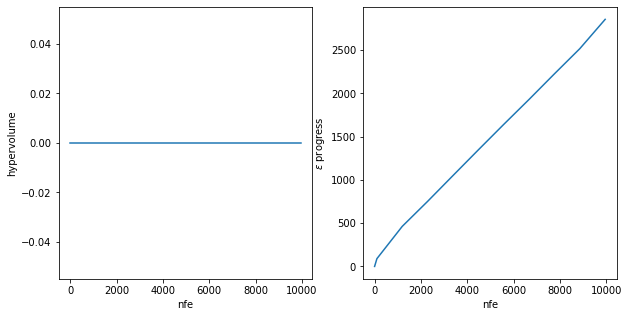

<Figure size 432x288 with 0 Axes>

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,5))
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
#fig.legend()
plt.show()
plt.savefig('Hypervol_noo100_nfe1e4_and_epsilon_0,1')

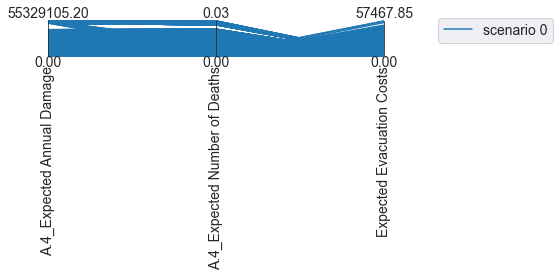

<Figure size 720x720 with 0 Axes>

In [4]:
colors = iter(sns.color_palette())
data = results[0][0].iloc[:, 5::]
limits = parcoords.get_limits(results[0][0].iloc[:, 5::][['A.4_Expected Annual Damage', 
                                'A.4_Expected Number of Deaths','Expected Evacuation Costs']])

#determine thresholds based on the maxima that can be acquierd 
max_expected_annual_damage = float(data[['A.4_Expected Annual Damage']].max())
max_number_deaths = float(data[['A.4_Expected Number of Deaths']].max()) 
max_evacuation_costs = float(data[['Expected Evacuation Costs']].max()) 

limits.loc[0, 'A.4_Expected Annual Damage'] = max_expected_annual_damage
limits.loc[0, 'A.4_Expected Number of Deaths'] = max_number_deaths 
limits.loc[0, 'Expected Evacuation Costs'] = max_evacuation_costs 
limits.loc[1, :] = 0

paraxes = parcoords.ParallelAxes(limits)

for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    sns.set(rc = {'figure.figsize':(10,10)})
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()

plt.savefig('Tradeoffs__noo100_nfe1e4_eps_0,1')

## Deep Uncertainty 
Reevaluate under deep uncertainty 

In [5]:
#specify the policies 

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:31]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)
        

In [6]:
#randomly select 50 policies 

sampled_policies = random.sample(policies, 50)

In [7]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 

with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(100, policies=sampled_policies)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 50 policies * 1 model(s) = 5000 experiments
100%|██████████████████████████████████████| 5000/5000 [55:31<00:00,  1.50it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.



In [8]:
experiments_deep, outcomes_deep = reeevaluation_results

#determine thresholds  
# max_expected_annual_damage = float(data[['A.4_Expected Annual Damage']].max())
# max_number_deaths = float(data[['A.4_Expected Number of Deaths']].max()) 
# max_evacuation_costs = float(data[['Expected Evacuation Costs']].max()) 

# max_expected_annual_damage = 9.28e+05
# max_number_deaths = 0.00009
# max_evacuation_costs = 4000

thresholds = {'A.4_Expected Number of Deaths':max_number_deaths, 
              'A.4_Expected Annual Damage':max_expected_annual_damage,
             'Expected Evacuation Costs':max_evacuation_costs}

overall_scores = {}
for policy in experiments_deep.policy.unique():
    logical = experiments_deep.policy == policy
    scores = {}
    for k, v in outcomes_deep.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

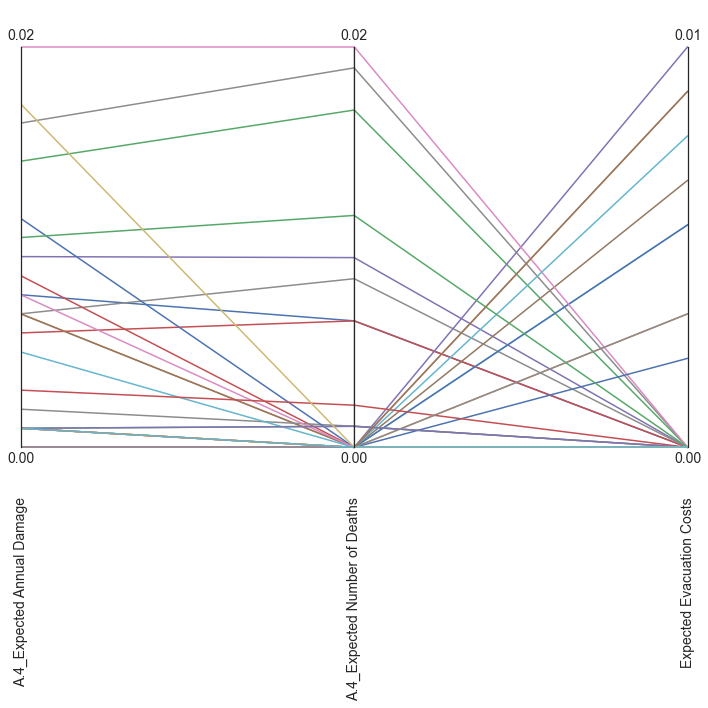

In [9]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

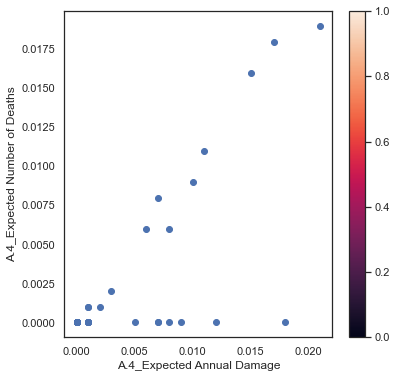

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(overall_scores['A.4_Expected Annual Damage'], overall_scores['A.4_Expected Number of Deaths'])
plt.colorbar(sc)

ax.set_xlabel('A.4_Expected Annual Damage')
ax.set_ylabel('A.4_Expected Number of Deaths')
plt.show()